DSC 478 Project David Guo Image Classification

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sn
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import decomposition
from sklearn import svm 
import tensorflow as tf

from sklearn.metrics import confusion_matrix

%matplotlib inline

__Intro__

The focal point of this project will be the analysis of several images utilizing clustering and classification methods. 

In [2]:
df = pd.read_csv('train.csv')
print("Shape of data", df.shape)
df.head()

Shape of data (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The data, which we obtained from Kaggle, contains 785 columns. The first column, called "label", represents the digit that was drawn by the user. The remaining columns contain the pixel-values of their associated image. The dimensions of each image are 28 x 28 pixels (for a total of 784 pixels). Each pixel has a single pixel-value associated with it, indicating the relative lightness or darkness of said pixel. This pixel-value is an integer between 0 and 255; the greater the pixel-value, the darker the pixel.


In [3]:
rs = 11

def stratified(df, n):
    df = pd.DataFrame(df)
    df2 = df
    df_subset = pd.DataFrame()

    for i in range(10):
        df_sub_num = df2[df2['label'] == i].sample(n = n, random_state = rs)
        sub_frames = [df_subset, df_sub_num]
        df_subset = pd.concat(sub_frames)
        df2 = df2.drop(df_sub_num.index)

    df_sub_x = df_subset.drop(['label'], axis = 1)
    df_sub_y = df_subset['label']

    df_2_x = df2.drop(['label'], axis = 1)
    df_2_y = df2['label']
    
    return df_subset, df_sub_x, df_sub_y, df_2_x, df_2_y

df_subset, df_sub_x, df_sub_y, df_2_x, df_2_y = stratified(df, 200)

Since the data has a lot of rows, running certain models on the data will take a really long time. Therefore, I wrote a function that subsetted the data by stratify sampling, so that I could get 200 samples from each digit, with a total of 2000 samples.   

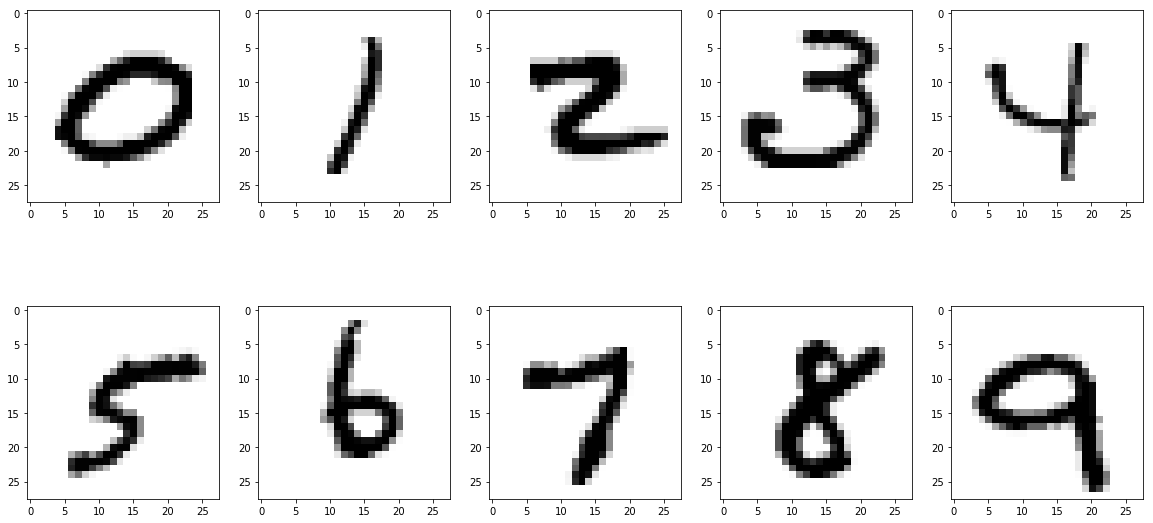

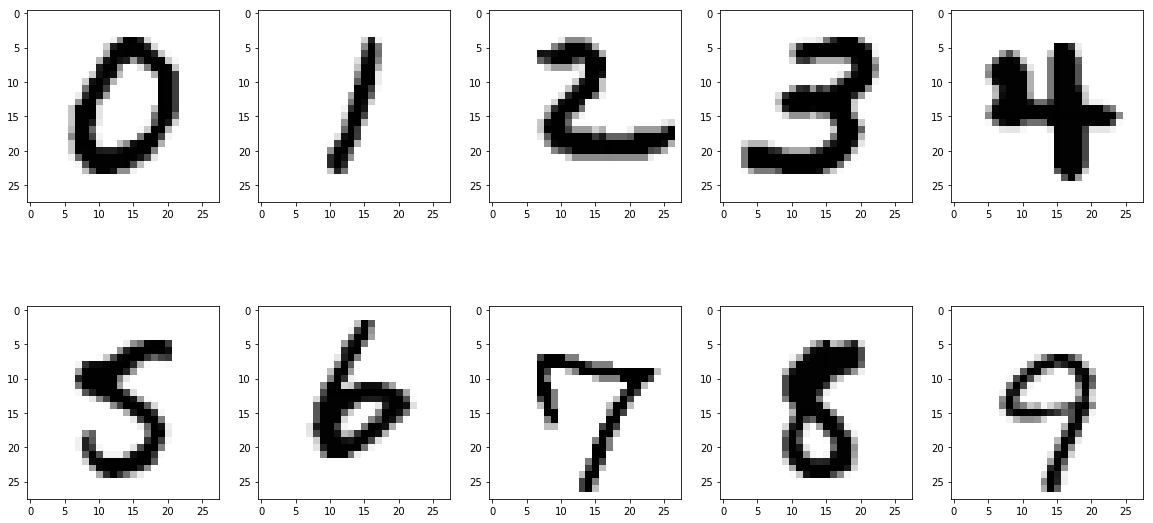

In [4]:
fig = plt.figure(figsize=(20,10))
for i in range(0,10):
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(df_sub_x.iloc[i*200].values.reshape(28,28), cmap='gray_r')
    
fig = plt.figure(figsize=(20,10))
for i in range(0,10):
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(df_sub_x.iloc[(i)*200+1].values.reshape(28,28), cmap='gray_r')


The graphs show each row plotted as a 28 by 28 diagram. Each graph shows a number from 0-9. As you can see, each individual number looks a little different from one row to the next. 

__Clustering__

Completeness of Clusters: 0.47957856175777996
Homogeneity of Clusters: 0.47467069626657604


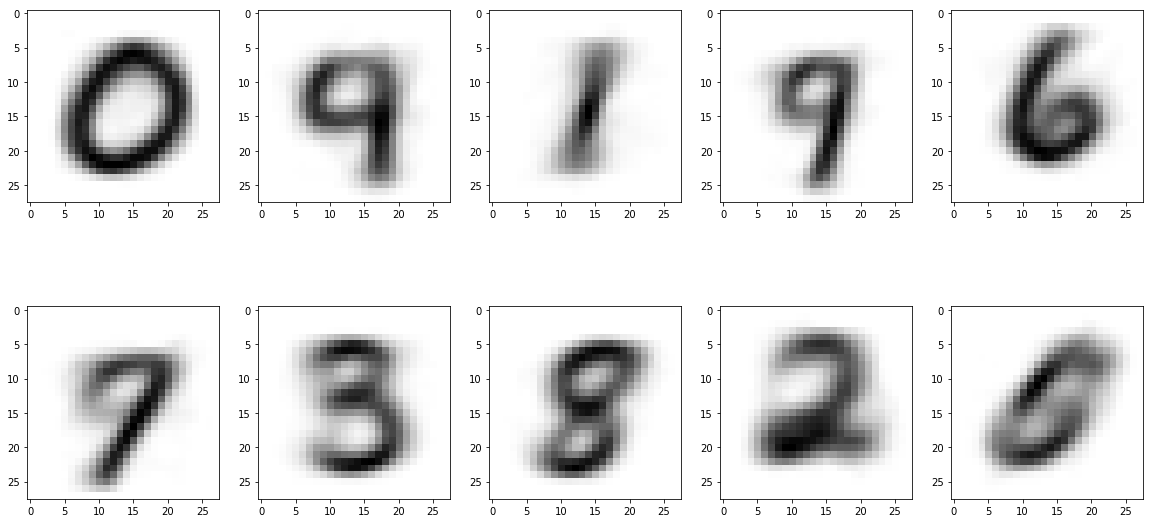

In [5]:
kMeans = KMeans(n_clusters = 10, random_state = rs)
kMeans = kMeans.fit(df_sub_x)
centroids_seg = kMeans.cluster_centers_

fig = plt.figure(figsize=(20,10))
for i in range(0,10):
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(centroids_seg[i].reshape(28,28),cmap='gray_r')
    
cs_km = completeness_score(df_sub_y, kMeans.labels_)
hs_km = homogeneity_score(df_sub_y, kMeans.labels_)

print('Completeness of Clusters: '+  str(cs_km))
print('Homogeneity of Clusters: '+ str(hs_km))

I ran a k means clustering with 10 clusters on the data and calculated the homogenity and completeness scores. The scores aren't very high, at around 0.48 for completeness and 0.47 for homogeneity. It looks like the clustering process doesn't cluster all 10 numbers perfectly. Looking at the plots, the clustering process seems to have trouble separating 4s, 7s, and 9s, as the second plot from the left on the first row, fourth plot from the left on the first row, first plot from the left on the second row all look similar. The fifth plot from the left in the second row looks mostly like a 5, but it also could look like a 6 and 5 were blended together, so the clustering process seems to also have trouble separating a 6 from a 5.

__KNN with regular dataset__

In [6]:
df_sub_train, df_sub_x_test, df_sub_y_test, df_sub_x_train, df_sub_y_train = stratified(df_subset, 40)


For splitting the data into training and test, I wanted to get the same amount of each number (40 each) for my test set, so I did stratified sampling again for my testing set and removed the these testing set rows from my training set. I had 400 samples for my testing set (40 of each number) and 1600 samples for my training set (160 of each number) . 

In [7]:
grid_params = {
    'n_neighbors' : [3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

gs_img = GridSearchCV(KNeighborsClassifier(), grid_params, cv = 3, n_jobs = -1)

gs_res = gs_img.fit(df_sub_x_train, df_sub_y_train)

knn_best = gs_res.best_estimator_

print(knn_best)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')


/Users/davidguo/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


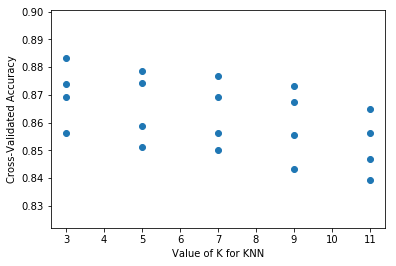

In [8]:
grid_mean_scores = [result.mean_validation_score for result in gs_res.grid_scores_]
n_nei = [3,3,5,5,7,7,9,9,11,11,3,3,5,5,7,7,9,9,11,11]
plt.scatter(n_nei, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

I did hyperparameter tuning for my KNN model. It looks like the KNN model with the highest accuracy is the model with 3 neighbors, using euclidean distance and distance weighting. Looking at the scatterplot, it looks like overall the accurracy tends to decrease as the number of neighbors increase.

Classification report for training set KNN with 3 neighbors:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       160
          1       1.00      1.00      1.00       160
          2       1.00      1.00      1.00       160
          3       1.00      1.00      1.00       160
          4       1.00      1.00      1.00       160
          5       1.00      1.00      1.00       160
          6       1.00      1.00      1.00       160
          7       1.00      1.00      1.00       160
          8       1.00      1.00      1.00       160
          9       1.00      1.00      1.00       160

avg / total       1.00      1.00      1.00      1600

Classification report for testing set KNN with 3 neighbors:
             precision    recall  f1-score   support

          0       0.93      1.00      0.96        40
          1       0.93      1.00      0.96        40
          2       0.92      0.88      0.90        40
          3       0.94     

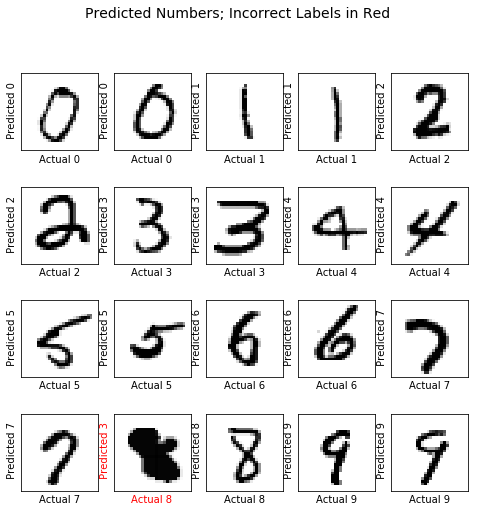

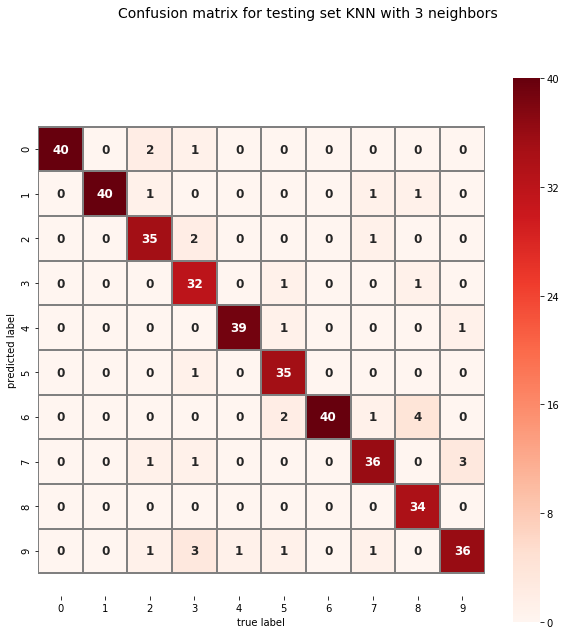

In [9]:
knn_fit = knn_best.predict(df_sub_x_train)
print("Classification report for training set KNN with 3 neighbors:")
print(classification_report(df_sub_y_train, knn_fit))

knn_fit = knn_best.predict(df_sub_x_test)
print("Classification report for testing set KNN with 3 neighbors:")
print(classification_report(df_sub_y_test, knn_fit))

target_names = [0,1,2,3,4,5,6,7,8,9]
fig, ax = plt.subplots(4, 5, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(df_sub_x_test.iloc[i*20].values.reshape(28, 28), cmap='gray_r')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(" Predicted " + str(knn_fit[i*20]),
                   color='black' if knn_fit[i*20] == df_sub_y_test.iloc[i*20] else 'red')
    axi.set_xlabel("Actual " + str(df_sub_y_test.iloc[i*20]),
                  color='black' if knn_fit[i*20] == df_sub_y_test.iloc[i*20] else 'red')

fig.suptitle('Predicted Numbers; Incorrect Labels in Red', size=14);

mat = confusion_matrix(df_sub_y_test, knn_fit)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(mat.T, square=True, linecolor='grey', linewidths=1, annot=True, 
            fmt='d', cbar=True, cmap='Reds', ax=ax, annot_kws={"fontsize":12, "weight":"bold"},
            xticklabels=[0,1,2,3,4,5,6,7,8,9],
            yticklabels=[0,1,2,3,4,5,6,7,8,9])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('Confusion matrix for testing set KNN with 3 neighbors', size=14);
plt.xlabel('true label')
plt.ylabel('predicted label');

I ran the best KNN model on the training set and got all the predictions correct. 

I ran the best KNN model on the testing set, and I got a 0.92 for precision, recall, and accuracy. From looking at the classification report, it looks like some numbers were harder to classify than others. For example, 3 had an f1-score of 0.86. It looks like almost all the predicted labels for 3 were correct (precision was 0.94), but there were only 32 predictions for 3 resulting in a recall of 0.8. On the other hand, 6 had an f1 score of 0.92. While all the 6s were identified correctly, there were a other numbers that weren't 6s that were identified as 6s, so the recall (1) was somewhat higher than the precision (0.85). There was also 4 with around the same precision and recall (0.95 and 0.97), so there were 2 false positives and 1 false negative, and 0,1,and 4 had the highest f1 scores. 

The F1 score difference between the training and testing set was 0.08, so I don't think there was much overfitting. 

From looking at the classified images plot, it looks like all the digits that were classified correctly were drawn pretty clearly. The 8 that was misclassified as a 3 doesn't look very clearly drawn. 

__PCA__

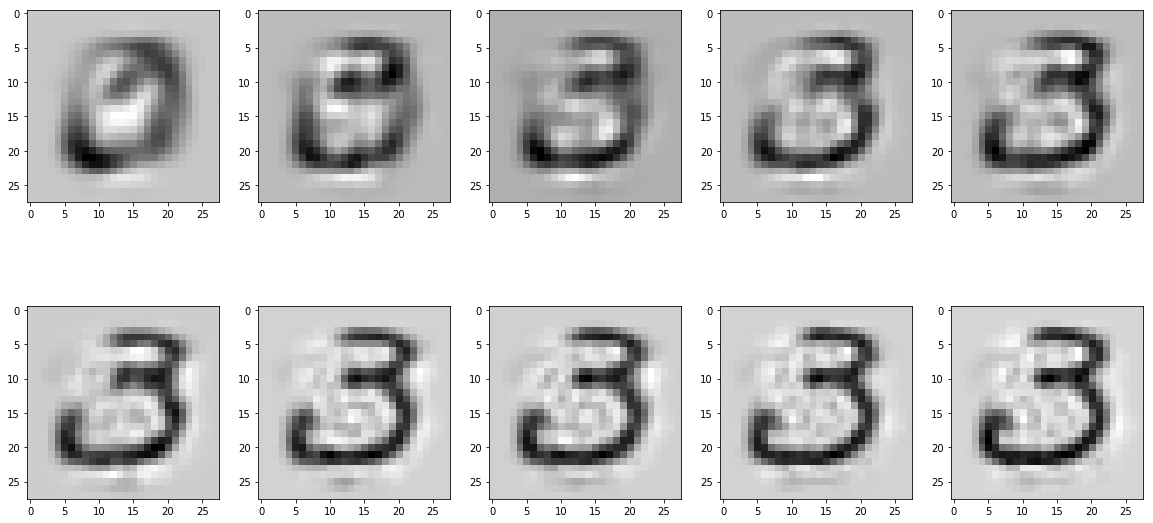

In [10]:
pca = decomposition.PCA(n_components=100, random_state = rs)
pca_fit = pca.fit(df_sub_x).transform(df_sub_x)
ratios = pca.explained_variance_ratio_
totals = []
total = 0
for i in range(len(ratios)):
    total += ratios[i]
    totals.append(total)
    

    
fig = plt.figure(figsize=(20,10))
for i in range(0,10):
    
    j = (i+1)*10
       
    pca_img = decomposition.PCA(n_components=j, random_state = rs)
    pca_fit_img = pca_img.fit(df_sub_x).transform(df_sub_x)
    pca_inv = pca_img.inverse_transform(pca_fit_img)
    
    ax = fig.add_subplot(2,5,i+1)
    plt.imshow(pca_inv[600].reshape(28,28), cmap='gray_r')
               





I ran principal component analaysis first with 100 components on the dataset. For the images, I did 10 PCA transformations, one with 10 components, one with 20, and so on. I did an inverse transformation of PCA transformed data. I then plotted one row of the resulting transformed dataset. As you can see looking at the plots, the number 3 starts off looking burry with 10 components, and then gradually begins to clearly look like a 3 as more principal components are added. 

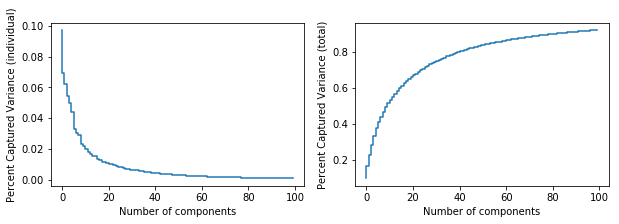

In [11]:
fig = plt.figure(figsize=(10,3))
ax1 = plt.subplot(121)
  

ax1.step(range(0,100), ratios, alpha = 1)
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Percent Captured Variance (individual)')

ax2 = plt.subplot(122)
ax2.step(range(0,100), totals, alpha = 1)
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Percent Captured Variance (total)')



I plotted the percentage of variance captured for each component for 100 PCs and for total, and I saw that there wasn't much more variance gain per component added after around 15-20 compoents. 

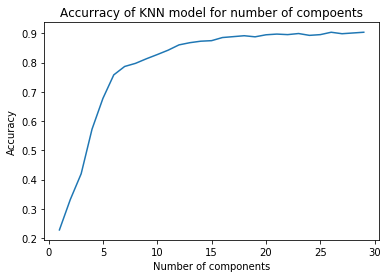

In [12]:
def pca_knn(n):
    pcan = decomposition.PCA(n_components = n, random_state = rs)
    pca_nfit = pcan.fit(df_sub_x).transform(df_sub_x)

    pcadf = pd.DataFrame(pca_nfit)
    subindex = df_sub_y.index

    index_dict = {}

    for i in range(2000):
        index_dict[i] = subindex[i]

    pcadf = pcadf.rename(index = index_dict)

    pcadf = pd.concat([pcadf, df_sub_y], axis = 1)

    
    df_pca_train, df_pca_x_test, df_pca_y_test, df_pca_x_train, df_pca_y_train = stratified(pcadf, 40)
    
    knn_pca = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
    
    knn_pca = knn_pca.fit(df_pca_x_train, df_pca_y_train)


    knn_scores = cross_validation.cross_val_score(knn_pca, df_pca_x_train, df_pca_y_train, cv=3)
    
    return (np.mean(knn_scores))

knn_pca_scores = []

for i in range(1, 30):
    knn_pca_scores.append(pca_knn(i))

plt.plot(range(1,30), knn_pca_scores)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.title('Accurracy of KNN model for number of compoents')

To see how many components I would need for KNN with principal component analysis, I ran KNN models with 1-30 components and did cross validation on the training set. From the graph, it looks like after 18 components, the accuracy doesn't increase by that much, as there is a slight drop off in accuracy at 19 components, so I will use a dataset with 18 PCA components to create more models. 

In [13]:
pcaless = decomposition.PCA(n_components = 18, random_state = rs)
pca_lessfit = pcaless.fit(df_sub_x).transform(df_sub_x)

km_pca = KMeans(n_clusters = 10, random_state = rs)
km_pca_fit = km_pca.fit(pca_lessfit)
centers_pca = km_pca_fit.cluster_centers_
labels_pca = km_pca_fit.labels_
preds_pca = km_pca_fit.predict(pca_lessfit)



cs_pca = completeness_score(df_sub_y, preds_pca)
hs_pca = homogeneity_score(df_sub_y,preds_pca)

print ('The completeness of 18 components :', cs_pca)
print ('The homogeneity of  18 components :', hs_pca)

The completeness of 18 components : 0.47267739814358883
The homogeneity of  18 components : 0.46786196478650416


I also ran K means clustering for 10 clusters on the data with 18 PCA components, and got around close to the same completeness, and homogeneity as clustering for the regular dataset (less .01 less for both scores), so I thought that using a transformed dataset with 18 PCA components would be fine for a KNN model. 

In [14]:
pcadf = pd.DataFrame(pca_lessfit)
subindex = df_sub_y.index

index_dict = {}

for i in range(2000):
    index_dict[i] = subindex[i]
    
pcadf = pcadf.rename(index = index_dict)

pcadf = pd.concat([pcadf, df_sub_y], axis = 1)

df_pca_train, df_pca_x_test, df_pca_y_test, df_pca_x_train, df_pca_y_train = stratified(pcadf, 40)

As with the regular pixels data set, I wanted to get the same amount of each number (40 each) for my test set, so I did stratified sampling again for my testing set and removed the these testing set rows from my training set. Like before, I had 400 samples for my testing set (40 of each number) and 1600 samples for my training set (160 of each number) . 

Classification report for training set KNN with 18 PCA components and 3 neighbors:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       160
          1       1.00      1.00      1.00       160
          2       1.00      1.00      1.00       160
          3       1.00      1.00      1.00       160
          4       1.00      1.00      1.00       160
          5       1.00      1.00      1.00       160
          6       1.00      1.00      1.00       160
          7       1.00      1.00      1.00       160
          8       1.00      1.00      1.00       160
          9       1.00      1.00      1.00       160

avg / total       1.00      1.00      1.00      1600

Classification report for testing set KNN with 18 PCA components and 3 neighbors:
             precision    recall  f1-score   support

          0       0.93      0.97      0.95        40
          1       0.95      1.00      0.98        40
          2       0.97      0.97    

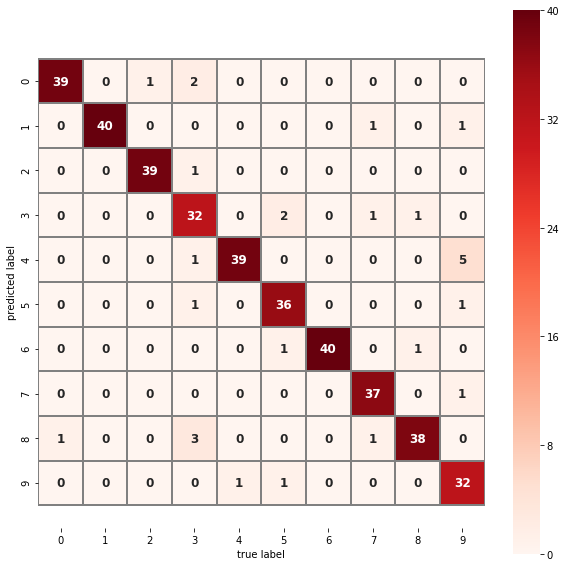

In [15]:
knn_pca = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

knn_pca = knn_pca.fit(df_pca_x_train, df_pca_y_train)
                               
knn_fit = knn_pca.predict(df_pca_x_train)
print("Classification report for training set KNN with 18 PCA components and 3 neighbors:")
print(classification_report(df_pca_y_train, knn_fit))

knn_fit = knn_pca.predict(df_pca_x_test)
print("Classification report for testing set KNN with 18 PCA components and 3 neighbors:")
print(classification_report(df_pca_y_test, knn_fit))

print("Confusion matrix for testing set KNN with 18 PCA components and 3 neighbors:")
mat = confusion_matrix(df_pca_y_test, knn_fit)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(mat.T, square=True, linecolor='grey', linewidths=1, annot=True, 
            fmt='d', cbar=True, cmap='Reds', ax=ax, annot_kws={"fontsize":12, "weight":"bold"},
            xticklabels=[0,1,2,3,4,5,6,7,8,9],
            yticklabels=[0,1,2,3,4,5,6,7,8,9])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');

I ran the best KNN model on the on the dataset with 18 PCA components.

All the training set predictions were correct. 

For the testing set, I got a 0.93 for precision, recall, and F1 score. So the KNN models for the dataset with 18 PCA components had a little higher accuracy. From looking at this classification report, and comparing it to the classification report for the KNN with the regular dataset, it looks like the F1 score for each individual number was similar or a little higher, though this model with the PCA data got 4 and 9 mixed up a little more, as there were 5 9s there were actually predicted as 4s.


__Support Vector Machines__

In [48]:
np.random.RandomState(1)
param_grid = {'C': [1, 5, 10],
              'gamma': [0.000001, 0.0001, 0.001, 0.01]}

grid_scv = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3)

grid_scv.fit(df_pca_x_train, df_pca_y_train)
print(grid_scv.best_params_)

{'C': 1, 'gamma': 1e-06}


I ran a hyperparameter tuning for a support vector classifier model. I used the PCA dataset since the reduced dimensionality will be able to capture more features with less components and clustering has shown that PCA with 20 components can have around the same amount of completeness, and homogeneity as the regular dataset with 784 features. I used the C and gamma as my parameters to look for, and I used rbf as the kernel due to the number of features we have, and used the default class weight as we have the same number of each digit. The gridsearch produced a gamma of 0.000001 and C of 5 as the best result.

Classification report for training set SVC with 18 PCA components:
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       160
          1       0.96      1.00      0.98       160
          2       0.99      1.00      1.00       160
          3       0.99      0.97      0.98       160
          4       0.98      1.00      0.99       160
          5       0.99      1.00      0.99       160
          6       1.00      0.99      1.00       160
          7       0.97      0.97      0.97       160
          8       0.99      0.98      0.98       160
          9       1.00      0.96      0.98       160

avg / total       0.99      0.99      0.99      1600

Classification report for testing set SVC with 18 PCA components:
             precision    recall  f1-score   support

          0       0.93      0.97      0.95        40
          1       1.00      1.00      1.00        40
          2       0.91      0.97      0.94        40
          3    

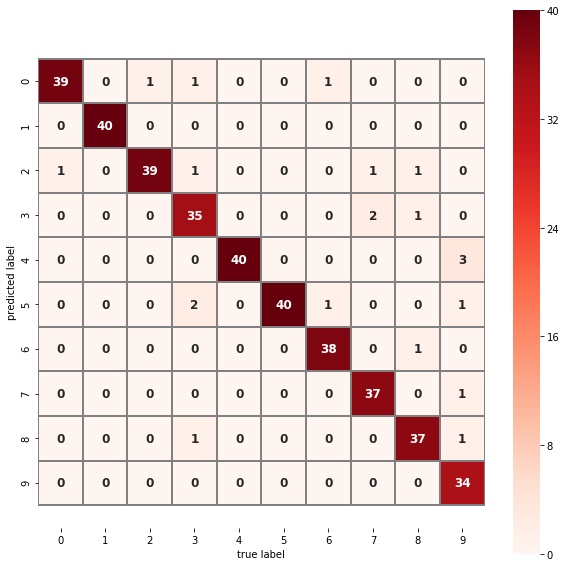

In [49]:
svc_model = grid_scv.best_estimator_

svc_yfit = svc_model.predict(df_pca_x_train)

print("Classification report for training set SVC with 18 PCA components:")
print(classification_report(df_pca_y_train, svc_yfit))

svc_yfit = svc_model.predict(df_pca_x_test)

print("Classification report for testing set SVC with 18 PCA components:")
print(classification_report(df_pca_y_test, svc_yfit))

print("Confusion matrix for testing set SVC with 18 PCA components:")
mat = confusion_matrix(df_pca_y_test, svc_yfit)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(mat.T, square=True, linecolor='grey', linewidths=1, annot=True, 
            fmt='d', cbar=True, cmap='Reds', ax=ax, annot_kws={"fontsize":12, "weight":"bold"},
            xticklabels=[0,1,2,3,4,5,6,7,8,9],
            yticklabels=[0,1,2,3,4,5,6,7,8,9])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label');

It looks like the SVC model was the most accurate model by a little bit with a test accuracy of 0.95, and all the digits had an F1 score of at least 0.9, though it looks like the training predictions has a few wrong wrong classifications, resulting in an accuracy of 0.99. One thing I noticed was that it looks this model was able to classify 5 the most accurately, as it had 40 correct classifications for 5 compared to 34 and 35 on the other two models. 

__Neural Networks__

0.8875
0.9025


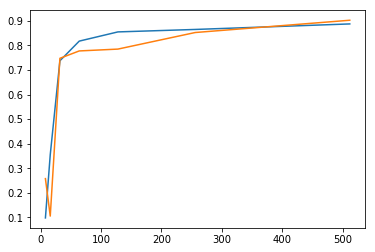

In [50]:

def nn(k, train, target, testx, testy, hid):
    if hid == 1:
        mlp = MLPClassifier(hidden_layer_sizes=(k,), max_iter=500, random_state = rs)
        mlp.fit(train, target)
        mlp_pred = mlp.predict(testx)
        acc = accuracy_score(mlp_pred, testy)
        return acc
    if hid == 2:
        mlp = MLPClassifier(hidden_layer_sizes=(k,k), max_iter=500, random_state = rs)
        mlp.fit(train, target)
        mlp_pred = mlp.predict(testx)
        acc = accuracy_score(mlp_pred, testy)
        return acc

lay = [8,16,32,64,128,256,512]
num = []
for i in lay:
    num.append(nn(i, df_sub_x_train, df_sub_y_train, df_sub_x_test, df_sub_y_test, 1))
plt.plot(lay,num)
print(max(num))

lay = [8,16,32,64,128,256,512]
num = []
for i in lay:
    num.append(nn(i, df_sub_x_train, df_sub_y_train, df_sub_x_test, df_sub_y_test, 2))
plt.plot(lay,num)
print(max(num))


Classification report for training set Neural Networks with 1 hidden layer:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       160
          1       1.00      1.00      1.00       160
          2       1.00      1.00      1.00       160
          3       1.00      1.00      1.00       160
          4       1.00      1.00      1.00       160
          5       1.00      1.00      1.00       160
          6       1.00      1.00      1.00       160
          7       1.00      1.00      1.00       160
          8       1.00      1.00      1.00       160
          9       1.00      1.00      1.00       160

avg / total       1.00      1.00      1.00      1600

Classification report for testing set Neural Networks with 2 hidden layers:
             precision    recall  f1-score   support

          0       0.89      0.97      0.93        40
          1       1.00      0.97      0.99        40
          2       0.89      0.85      0.87       

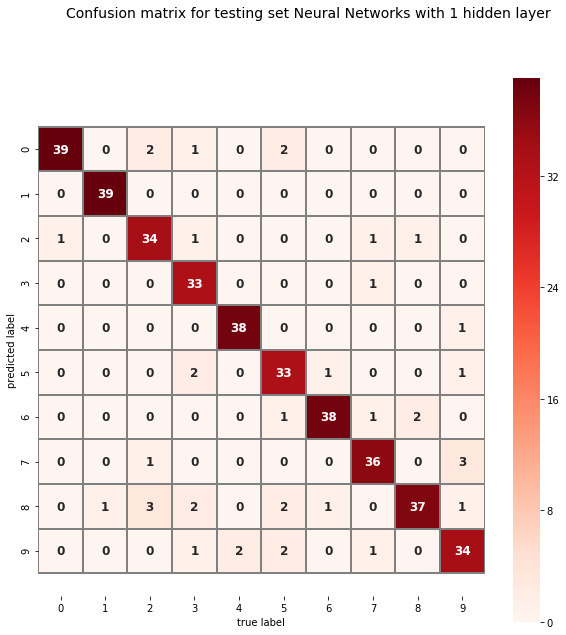

In [51]:
mlp = MLPClassifier(hidden_layer_sizes=(512,512), max_iter=500, random_state = rs)
mlp.fit(df_sub_x_train, df_sub_y_train)

mlp_pred = mlp.predict(df_sub_x_train)
print("Classification report for training set Neural Networks with 1 hidden layer:")
print(classification_report(df_sub_y_train, mlp_pred))

mlp_pred = mlp.predict(df_sub_x_test)
print("Classification report for testing set Neural Networks with 2 hidden layers:")
print(classification_report(df_sub_y_test, mlp_pred))


mat = confusion_matrix(df_sub_y_test, mlp_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(mat.T, square=True, linecolor='grey', linewidths=1, annot=True, 
            fmt='d', cbar=True, cmap='Reds', ax=ax, annot_kws={"fontsize":12, "weight":"bold"},
            xticklabels=[0,1,2,3,4,5,6,7,8,9],
            yticklabels=[0,1,2,3,4,5,6,7,8,9])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.suptitle('Confusion matrix for testing set Neural Networks with 1 hidden layer', size=14);
plt.xlabel('true label')
plt.ylabel('predicted label');

I ran a neural network model with 1 and 2 hidden layers with a different number of neurons and compared the two results. It looks like there isn't much of a performance increase for using 1 layer after using 128 neurons, and with 2 layers after using 256 neurons. The best f1 is at 0.9 max with 2 hidden layers and 512 neurons.

In [61]:
tf.random.set_seed(rs)

dnn = [[]]*10
X = np.array(df_sub_x_train)
Y = np.array(df_sub_y_train)
m, n = X.shape
yy = np.zeros(shape=m)
print("data size:", m, n)

for i in range(10):
    
    print('\t\t>>> training the model for digit {}  <<<'.format(i))
    
    dnn[i]=tf.keras.models.Sequential()
    dnn[i].add(tf.keras.layers.Dense(n, input_dim=n, activation='relu'))
    dnn[i].add(tf.keras.layers.Dense(int(n/2), activation='relu'))
    dnn[i].add(tf.keras.layers.Dense(28, activation='relu'))
    dnn[i].add(tf.keras.layers.Dense(1, activation='sigmoid'))
    dnn[i].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    yy[Y == i] = 1 # the label for model is set to 1 if the model is for that digit 
    yy[Y != i] = 0 # .. and zero for all other digits.
    dnn[i].fit(X, yy, epochs=15, batch_size=500)

data size: 1600 784
		>>> training the model for digit 0  <<<
Epoch 1/15
4/4 [==============================] - 0s 11ms/step - loss: 38.7287 - accuracy: 0.6612
Epoch 2/15
4/4 [==============================] - 0s 12ms/step - loss: 6.1508 - accuracy: 0.8875
Epoch 3/15
4/4 [==============================] - 0s 11ms/step - loss: 1.2861 - accuracy: 0.8938
Epoch 4/15
4/4 [==============================] - 0s 11ms/step - loss: 0.7445 - accuracy: 0.9638
Epoch 5/15
4/4 [==============================] - 0s 13ms/step - loss: 0.6386 - accuracy: 0.9500

In [62]:
# ~~~ TESTING ~~~

# pick the highest probability from each model output.


def MultiClass_Predict(xin, dnn):
    
    m, n = xin.shape
    ncls = len(dnn)
    ii = np.arange(0,ncls)    
    
    Y = np.zeros(shape=(m, ncls))
    for i in range(10):
        print(i, end='')
        yp = dnn[i].predict(xin)
        Y[:,i:i+1] = yp 
    ips = [0]*m
    for i in range(m):    
        ip = ii[Y[i] == np.max(Y[i])]
        ips[i] = ip[0]
        
    return ips

In [63]:
# with training data
xin = np.array(df_sub_x_train)
#y_train = np.array(tran_dat.iloc[:,0])
#yp_train = digit_predict(xin)
yp_train = MultiClass_Predict(xin, dnn)

0123456789

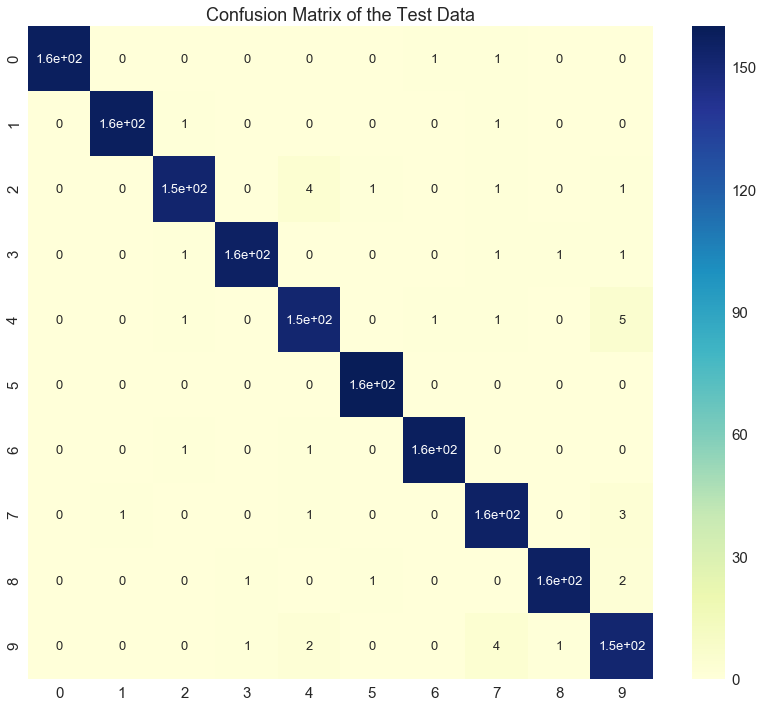

[[158   0   0   0   0   0   1   1   0   0]
 [  0 158   1   0   0   0   0   1   0   0]
 [  0   0 153   0   4   1   0   1   0   1]
 [  0   0   1 156   0   0   0   1   1   1]
 [  0   0   1   0 152   0   1   1   0   5]
 [  0   0   0   0   0 160   0   0   0   0]
 [  0   0   1   0   1   0 158   0   0   0]
 [  0   1   0   0   1   0   0 155   0   3]
 [  0   0   0   1   0   1   0   0 156   2]
 [  0   0   0   1   2   0   0   4   1 152]]


In [64]:
cmm_test = confusion_matrix(df_sub_y_train, yp_train)
cmmdf_test = pd.DataFrame(cmm_test, range(10), range(10))
fig = plt.figure(figsize = (14,12))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cmmdf_test, annot=True, annot_kws={"size": 13}, cmap="YlGnBu") # font size
plt.title('Confusion Matrix of the Test Data')
plt.show()
print(cmm_test)

In [65]:
# with training data
xin = np.array(df_sub_x_test)
#y_train = np.array(tran_dat.iloc[:,0])
#yp_train = digit_predict(xin)
yp_test = MultiClass_Predict(xin, dnn)

0123456789

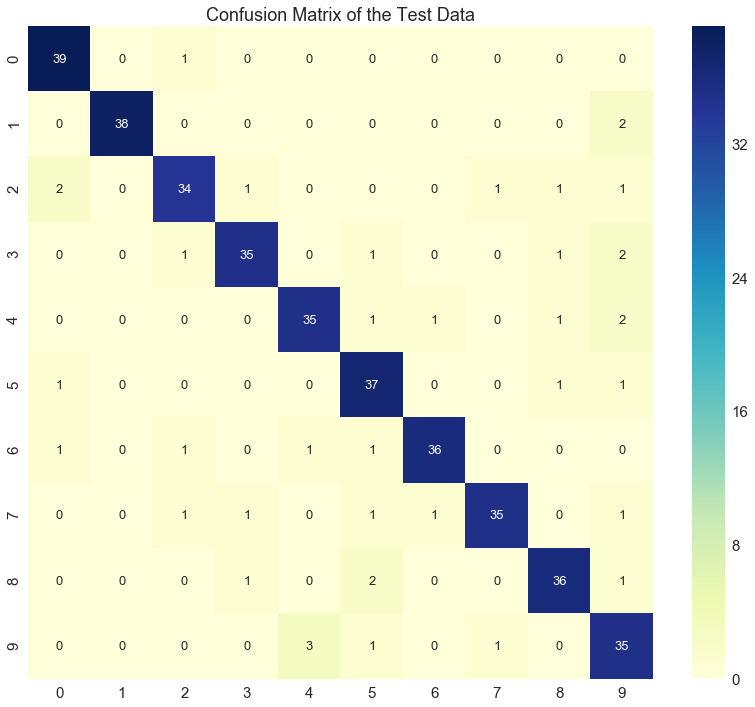

[[39  0  1  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  2]
 [ 2  0 34  1  0  0  0  1  1  1]
 [ 0  0  1 35  0  1  0  0  1  2]
 [ 0  0  0  0 35  1  1  0  1  2]
 [ 1  0  0  0  0 37  0  0  1  1]
 [ 1  0  1  0  1  1 36  0  0  0]
 [ 0  0  1  1  0  1  1 35  0  1]
 [ 0  0  0  1  0  2  0  0 36  1]
 [ 0  0  0  0  3  1  0  1  0 35]]


In [66]:
cmm_test = confusion_matrix(df_sub_y_test, yp_test)
cmmdf_test = pd.DataFrame(cmm_test, range(10), range(10))
fig = plt.figure(figsize = (14,12))
sn.set(font_scale=1.5) # for label size
sn.heatmap(cmmdf_test, annot=True, annot_kws={"size": 13}, cmap="YlGnBu") # font size
plt.title('Confusion Matrix of the Test Data')
plt.show()
print(cmm_test)

In [67]:
n = len(df_sub_y_train)
err_train = abs(df_sub_y_train - yp_train)
miss_i = [i for i in range(n) if err_train.iloc[i] != 0]
accu_train = (n-len(miss_i))/n

n = len(df_sub_y_test)
err_test = abs(df_sub_y_test - yp_test)
miss_j = [i for i in range(n) if err_test.iloc[i] != 0]
accu_test = (n-len(miss_j))/n

print("Accuracy of Training Data:", accu_train)
print(" Accuracy of Testing Data:", accu_test)

Accuracy of Training Data: 0.97375
 Accuracy of Testing Data: 0.9


I ran another neural network model with 2 hidden layers, this time I used ten different models and trained each digit with one of the ten models. I used that to predict on the testing data by combining the results that have highest prediction probability of a certain number among ten total models. The model has the same accuracy has the previous neural network model at 90%. 

__Conclusion__

It looks like the SVC model with 18 PCA components had the highest accuracy at 95%, then the KNN, then the Neural Networks. I could try to train more data if I had a faster computer; I think that could benefit the neural network model the most. For some misclassified digits that are hard to tell apart, I could try train more of those specific digits so the classifiers could work better.
